In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv("C:/Users/user/Downloads/final-dataset-parsed-and-polished.csv")

# Convert OperationEndTime to datetime
df['OperationEndTime'] = pd.to_datetime(df['OperationEndTime'], unit='m')
df.set_index('OperationEndTime', inplace=True)
df.sort_index(inplace=True)

# Get P_DataPoint columns
p_columns = [col for col in df.columns if col.startswith('P') and 'DataPoint' in col]

# Add ToolId to our analysis
print("Unique ToolIds:", df['ToolId'].unique())
print("Value counts:\n", df['ToolId'].value_counts())

Unique ToolIds: [   0    1    2 ... 1853 1854 1855]
Value counts:
 ToolId
1823    163
1767    159
1519    158
1386    157
1836    157
       ... 
1788      5
1855      4
845       2
524       1
839       1
Name: count, Length: 1856, dtype: int64


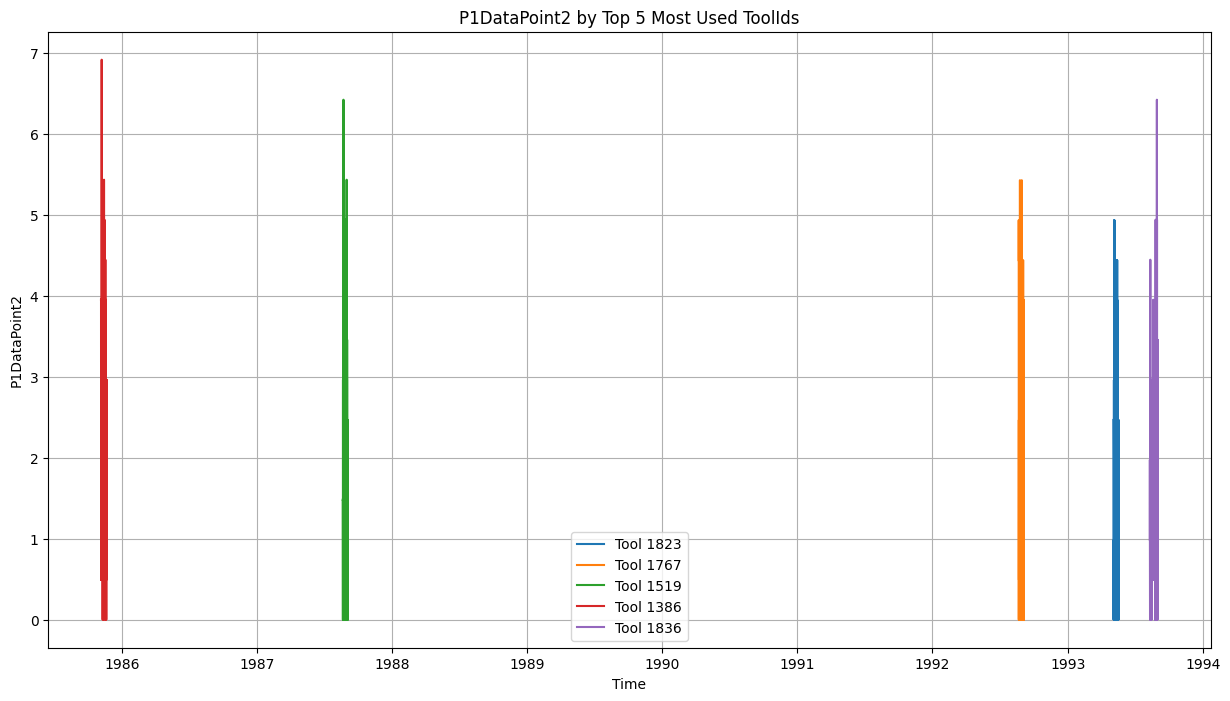

Top 5 most used ToolIds:
ToolId
1823    163
1767    159
1519    158
1386    157
1836    157
Name: count, dtype: int64


In [3]:
# Let's analyze one data point (P1DataPoint1) across different tools
target_column = 'P1DataPoint2'

# Get the top 5 most frequent ToolIds
top_5_tools = df['ToolId'].value_counts().head(5).index.tolist()

# Visualize only the top 5 tools
plt.figure(figsize=(15, 8))
for tool_id in top_5_tools:
    tool_data = df[df['ToolId'] == tool_id]
    plt.plot(tool_data.index, tool_data[target_column], label=f'Tool {tool_id}')
    
plt.title(f'{target_column} by Top 5 Most Used ToolIds')
plt.xlabel('Time')
plt.ylabel(target_column)
plt.legend()
plt.grid(True)
plt.show()

# Print the top 5 tools and their counts
print("Top 5 most used ToolIds:")
print(df['ToolId'].value_counts().head(5))

In [8]:
def analyze_tool(tool_id, target_col='P1DataPoint2'):
    print(f"\n{'='*50}")
    print(f"Analyzing Tool {tool_id} - {target_col}")
    print(f"{'='*50}")
    
    # Filter data for this tool
    tool_data = df[df['ToolId'] == tool_id][[target_col]].copy()
    tool_data.dropna(inplace=True)
    
    if len(tool_data) < 10:
        print(f"Not enough data for Tool {tool_id}")
        return 
    
    # 1. Basic visualization
    plt.figure(figsize=(12, 6))
    plt.plot(tool_data[target_col])
    plt.title(f'Tool {tool_id} - {target_col}')
    plt.grid(True)
    plt.show()
    
    # 2. Decomposition
    try:
        decomposition = seasonal_decompose(tool_data[target_col], period=24)
        plt.figure(figsize=(15, 8))
        plt.subplot(411)
        plt.plot(tool_data[target_col], label='Original')
        plt.legend()
        plt.subplot(412)
        plt.plot(decomposition.trend, label='Trend')
        plt.legend()
        plt.subplot(413)
        plt.plot(decomposition.seasonal, label='Seasonal')
        plt.legend()
        plt.subplot(414)
        plt.plot(decomposition.resid, label='Residual')
        plt.legend()
        plt.tight_layout()
        plt.show()
    except:
        print("Could not perform decomposition - possibly insufficient data")
    
    # 3. Stationarity test
    print("\nStationarity Test:")
    adf_test = adfuller(tool_data[target_col])
    print(f'ADF Statistic: {adf_test[0]}')
    print(f'p-value: {adf_test[1]}')
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print(f'\t{key}: {value}')
    
    # 4. ACF/PACF plots
    plt.figure(figsize=(12, 6))
    plot_acf(tool_data[target_col], lags=20, ax=plt.subplot(121))
    plot_pacf(tool_data[target_col], lags=20, ax=plt.subplot(122))
    plt.suptitle(f'Tool {tool_id} - {target_col}')
    plt.tight_layout()
    plt.show()
    # 5. ARIMA modeling with auto_arima
    # Split data
    split_idx = int(len(tool_data) * 0.8)
    train, test = tool_data[:split_idx], tool_data[split_idx:]
    
    # Use auto_arima to find best parameters
    try:
        model = auto_arima(train,
                          seasonal=True,  # set to False if you don't expect seasonality
                          m=24,          # seasonal period (24 for hourly daily seasonality)
                          trace=True,    # show progress
                          error_action='ignore',
                          suppress_warnings=True,
                          stepwise=True) # faster search
        
        print("\nAuto ARIMA Results:")
        print(model.summary())
        
        # Forecast
        forecast = model.predict(n_periods=len(test))
        
        # Plot
        plt.figure(figsize=(12, 6))
        plt.plot(train, label='Training')
        plt.plot(test, label='Actual')
        plt.plot(test.index, forecast, label='Forecast')
        plt.title(f'Tool {tool_id} - Auto ARIMA Forecast')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Metrics
        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))
        print(f'MAE: {mae:.2f}')
        print(f'RMSE: {rmse:.2f}')
    except Exception as e:
        print(f"Auto ARIMA modeling failed for this tool: {str(e)}")


Analyzing Tool 1823 - P1DataPoint2


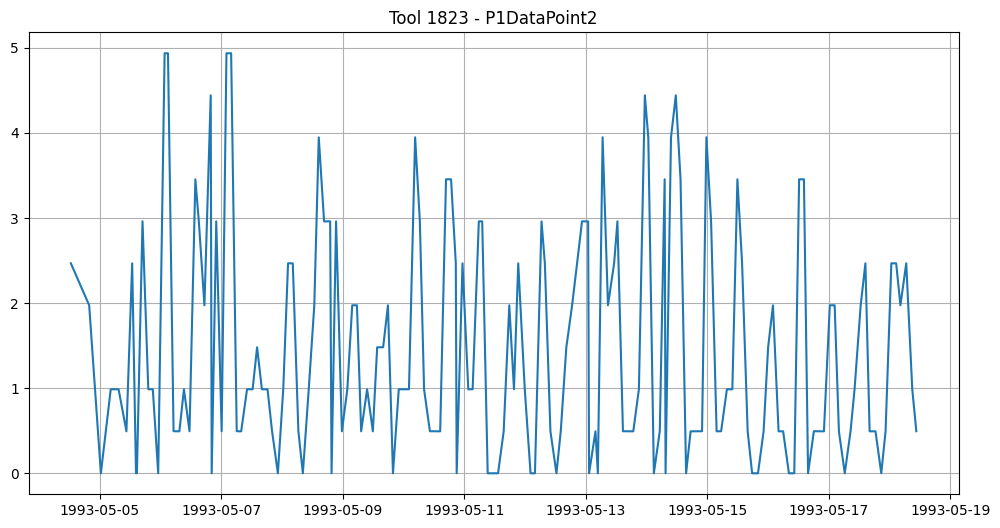

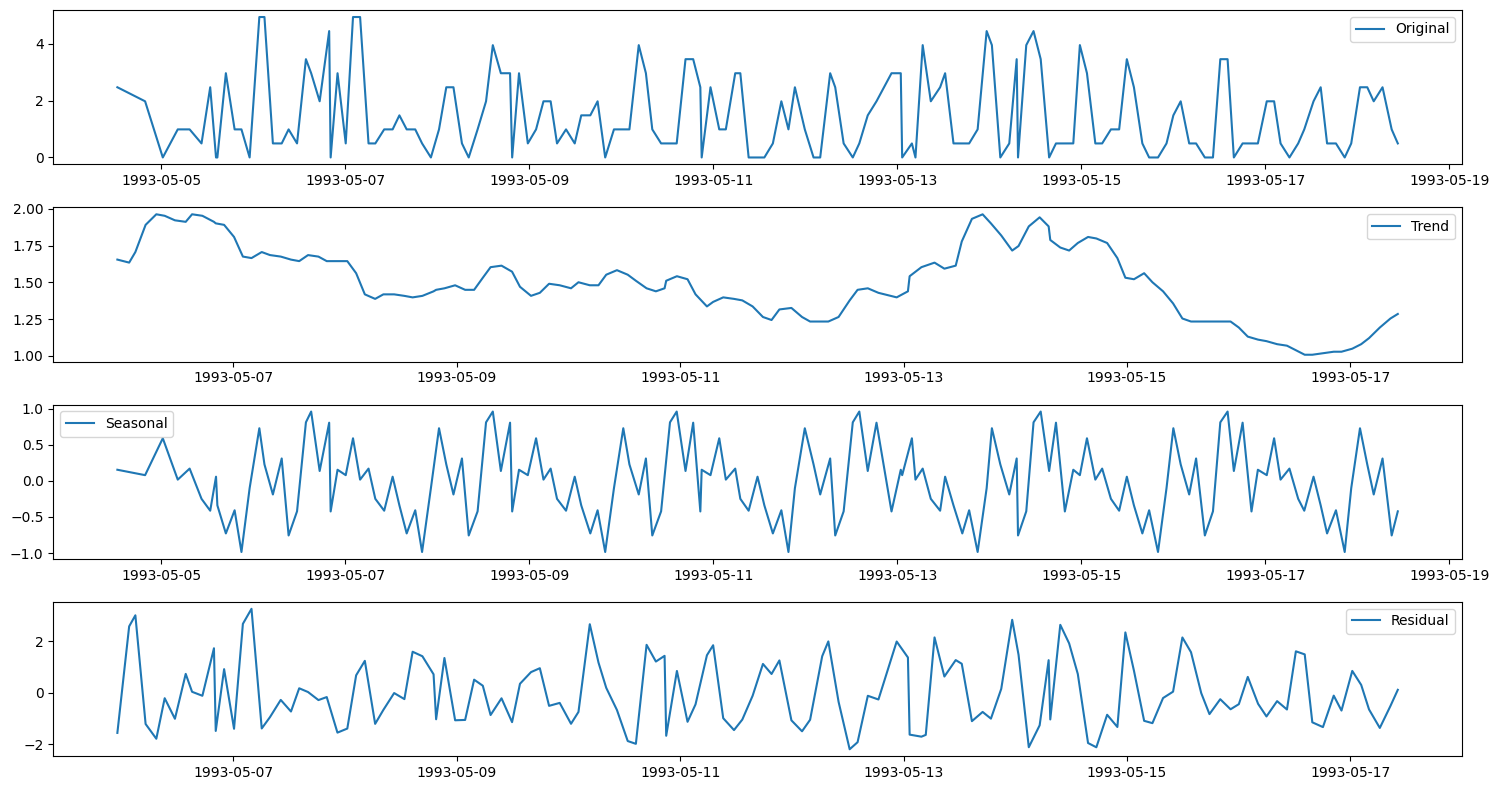


Stationarity Test:
ADF Statistic: -3.1949681221274697
p-value: 0.02027779787534401
Critical Values:
	1%: -3.4750180242954167
	5%: -2.8811408028842043
	10%: -2.577221358046935


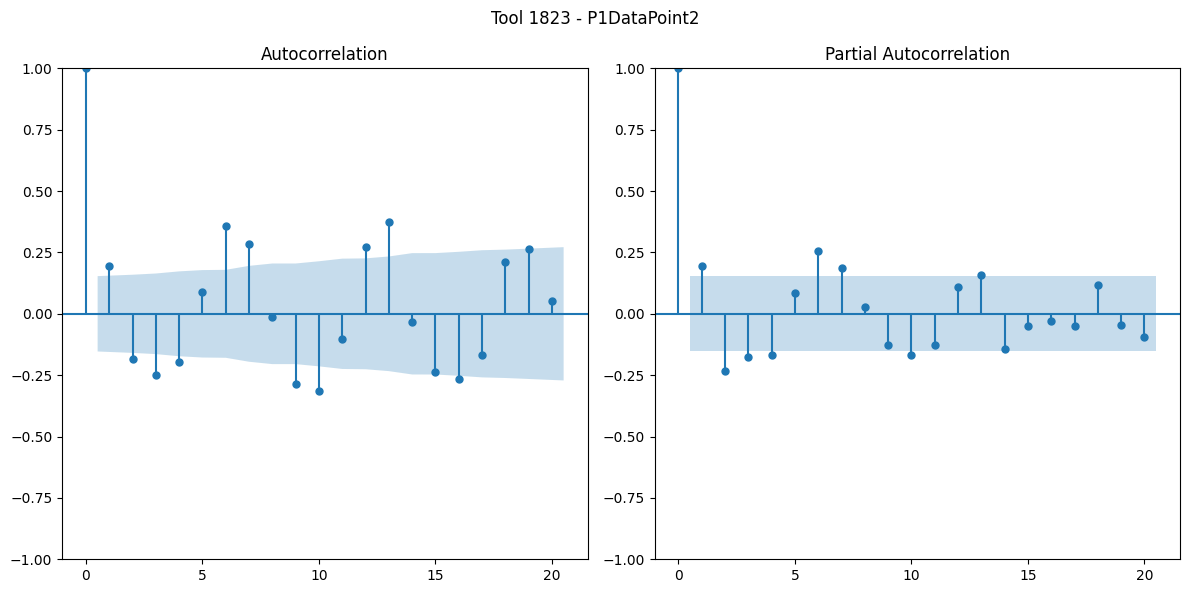

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=1.70 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=460.693, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=460.853, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=459.036, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=565.221, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=458.127, Time=0.05 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=459.350, Time=0.22 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=459.247, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[24] intercept   : AIC=456.774, Time=0.04 sec
 ARIMA(0,0,2)(1,0,0)[24] intercept   : AIC=457.943, Time=0.23 sec
 ARIMA(0,0,2)(0,0,1)[24] intercept   : AIC=457.637, Time=0.19 sec
 ARIMA(0,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(1,0,2)(0,0,0)[24] intercept   : AIC=455.743, Time=0.15 sec
 ARIMA(1,0,2)(1,0,0)[24] intercept   : AIC=45

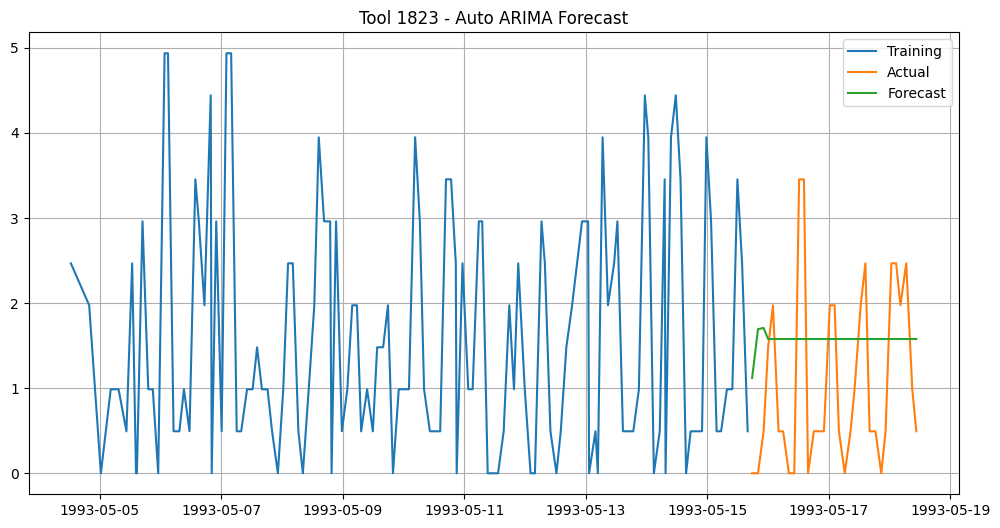

MAE: 1.04
RMSE: 1.14

Analyzing Tool 1767 - P1DataPoint2


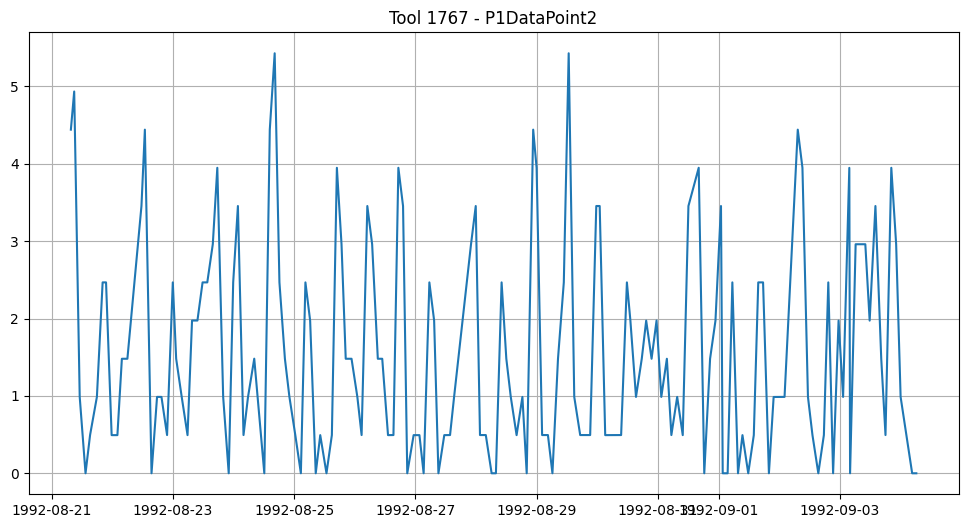

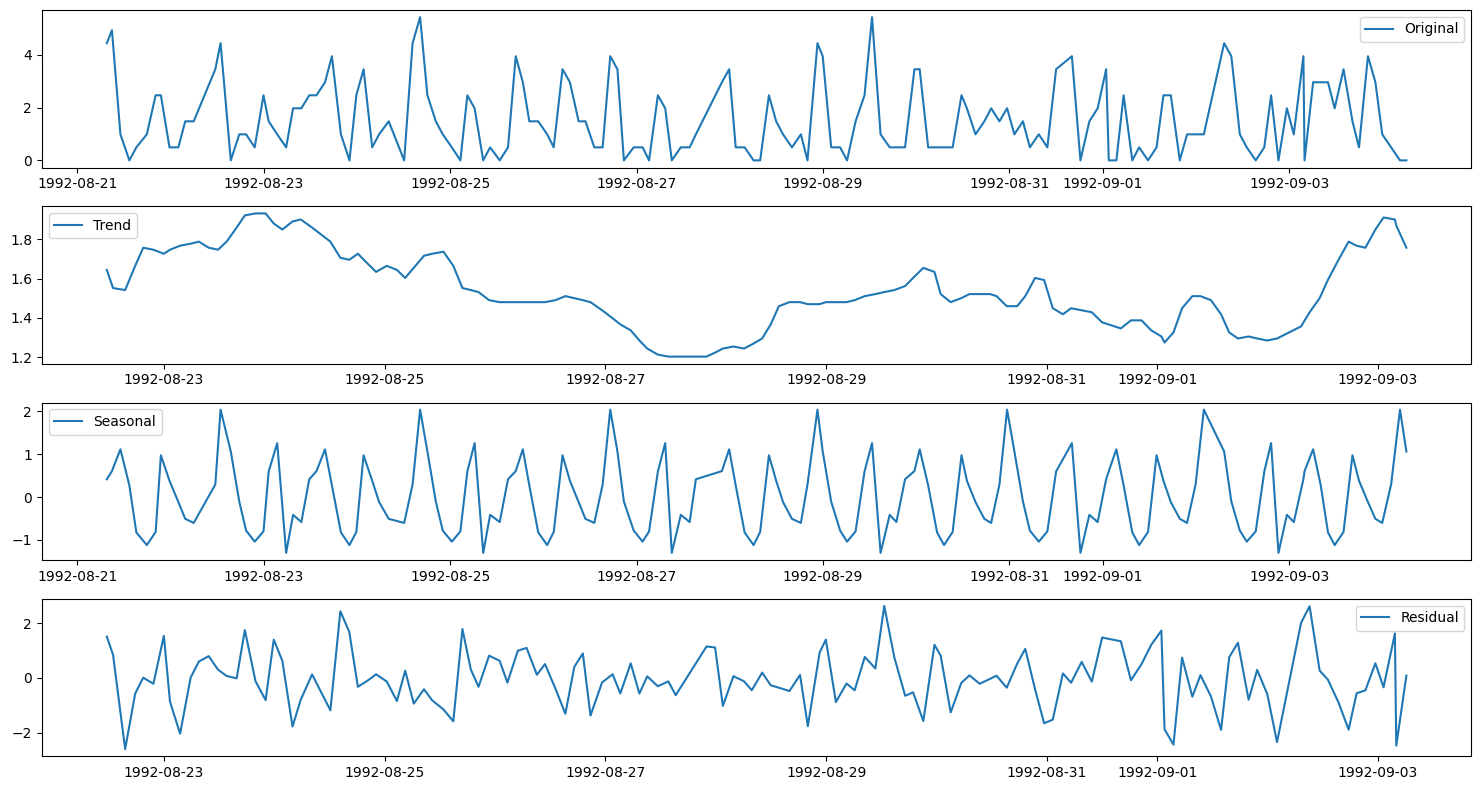


Stationarity Test:
ADF Statistic: -3.5214074444228323
p-value: 0.007454028351273776
Critical Values:
	1%: -3.4756368462466662
	5%: -2.8814104466172608
	10%: -2.5773652982553568


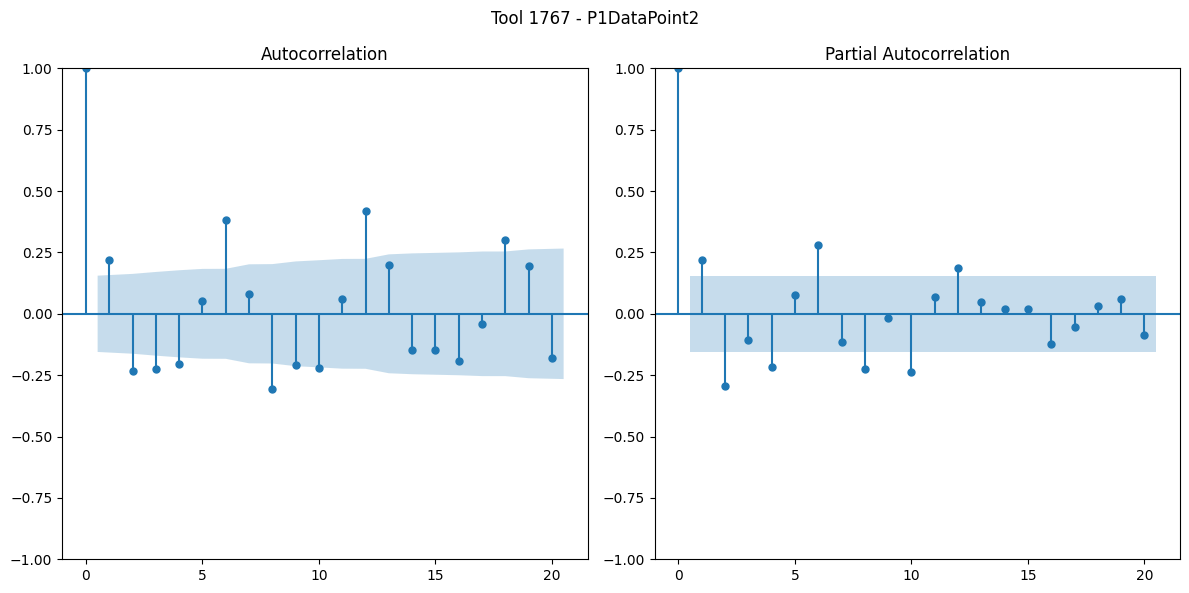

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=403.257, Time=1.45 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=446.326, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=414.392, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=413.867, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=548.284, Time=0.00 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=403.879, Time=0.61 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=401.259, Time=1.21 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=421.428, Time=1.55 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=403.256, Time=6.62 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=405.259, Time=5.17 sec
 ARIMA(1,0,2)(1,0,0)[24] intercept   : AIC=402.124, Time=0.71 sec
 ARIMA(2,0,1)(1,0,0)[24] intercept   : AIC=402.655, Time=0.71 sec
 ARIMA(3,0,2)(1,0,0)[24] intercept   : AIC=399.388, Time=1.60 sec
 ARIMA(3,0,2)(0,0,0)[24] intercept   : AIC=416.856, Time=0.23 sec
 ARIMA(3,0,2)(2,0,0)[24] intercep

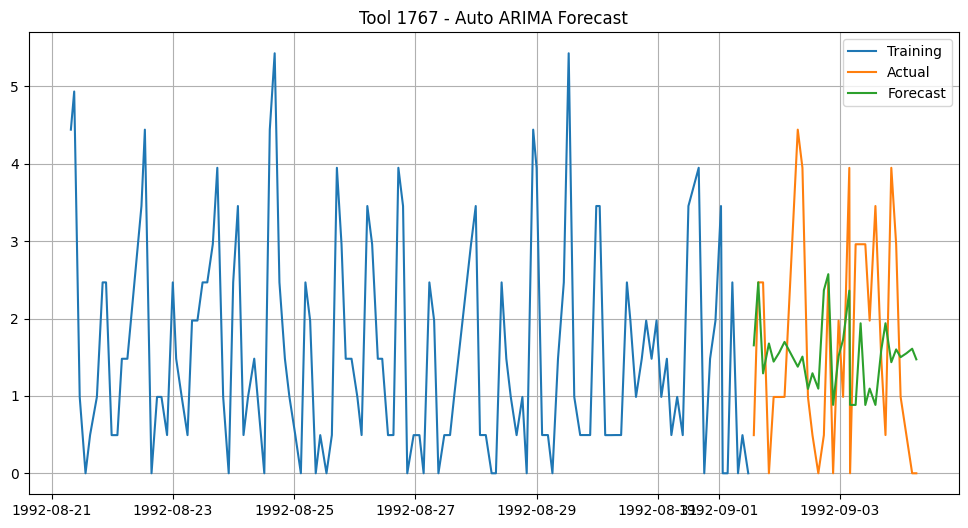

MAE: 1.20
RMSE: 1.43

Analyzing Tool 1519 - P1DataPoint2


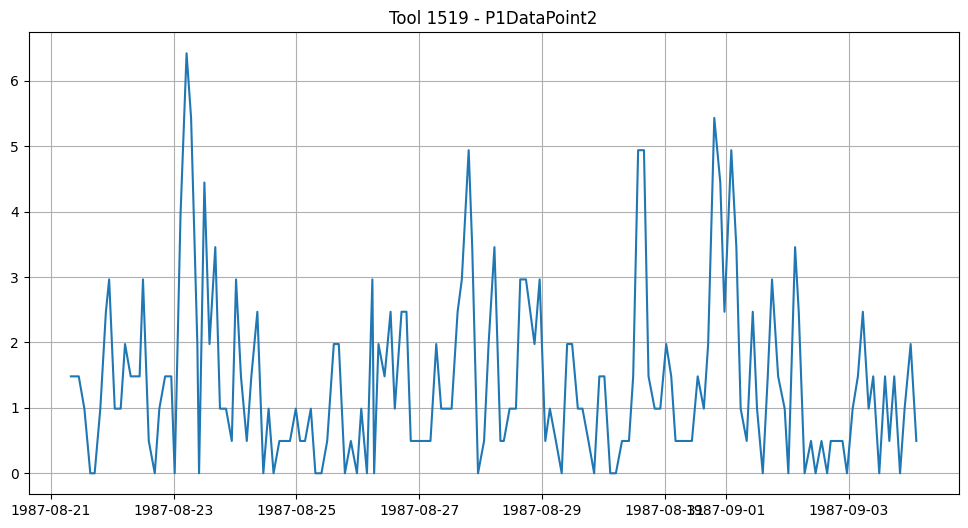

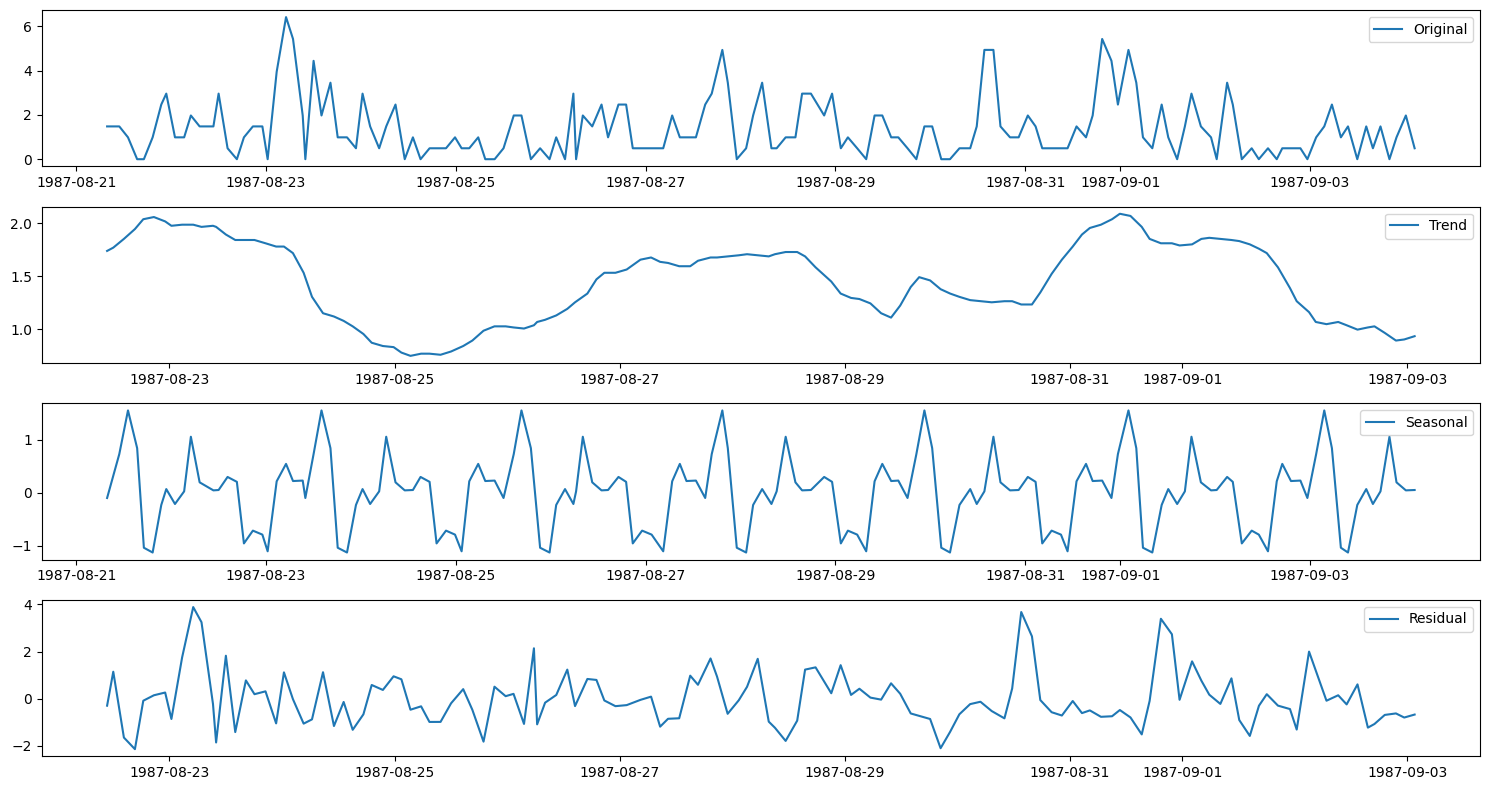


Stationarity Test:
ADF Statistic: -8.104278895513513
p-value: 1.2752147641837882e-12
Critical Values:
	1%: -3.472703119504854
	5%: -2.880131672353732
	10%: -2.5766826861130268


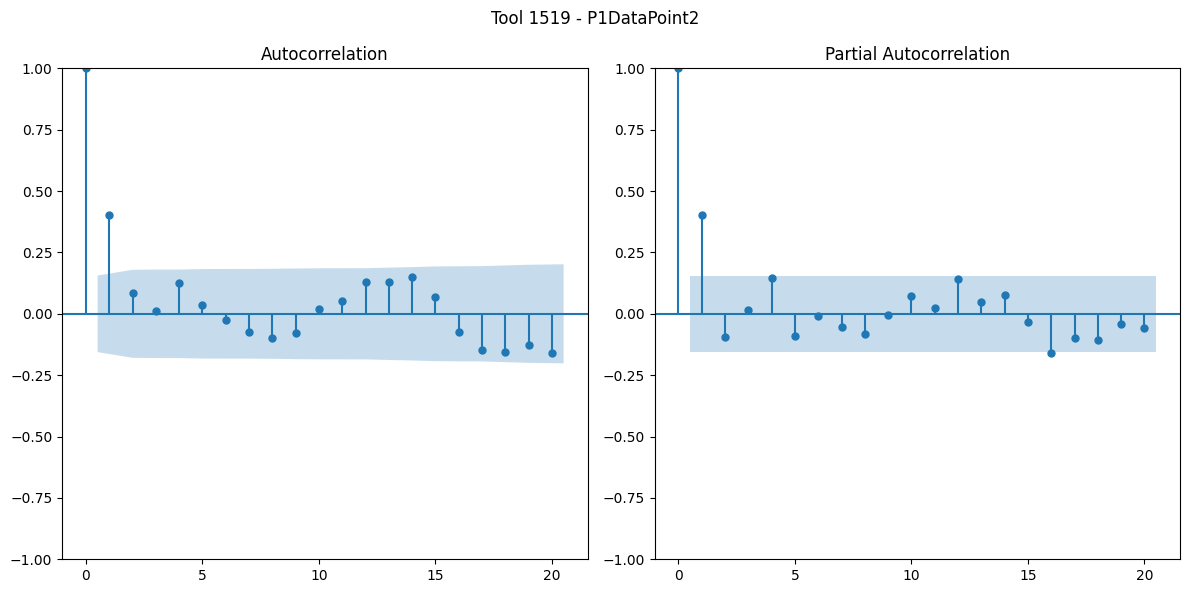

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=426.097, Time=1.21 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=443.814, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=422.473, Time=0.23 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=423.345, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=540.013, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=420.644, Time=0.02 sec
 ARIMA(1,0,0)(0,0,1)[24] intercept   : AIC=422.507, Time=0.15 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=423.976, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[24] intercept   : AIC=420.946, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=421.242, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=421.436, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[24] intercept   : AIC=422.943, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[24]             : AIC=444.024, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,0,0)[24] intercept
Total fit time: 2.458 seconds

Auto ARIMA Results:


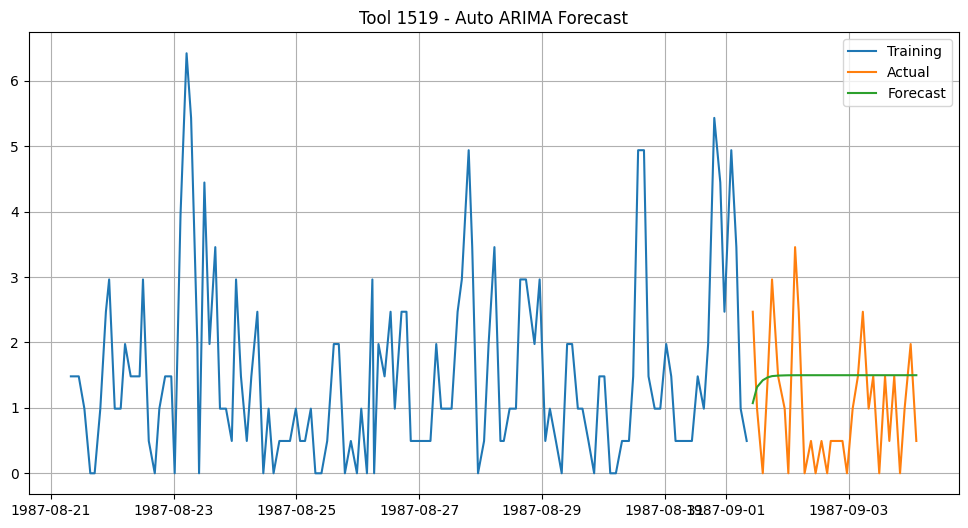

MAE: 0.90
RMSE: 1.06

Analyzing Tool 1386 - P1DataPoint2


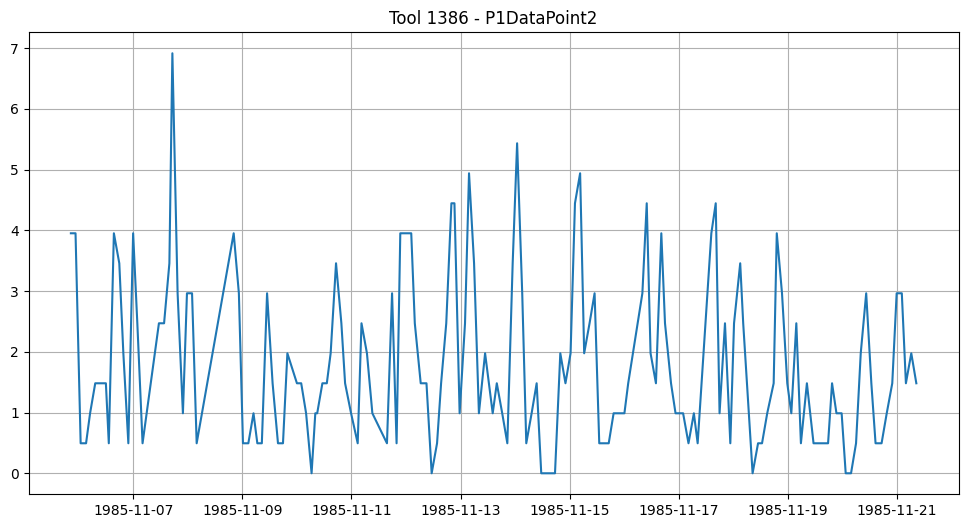

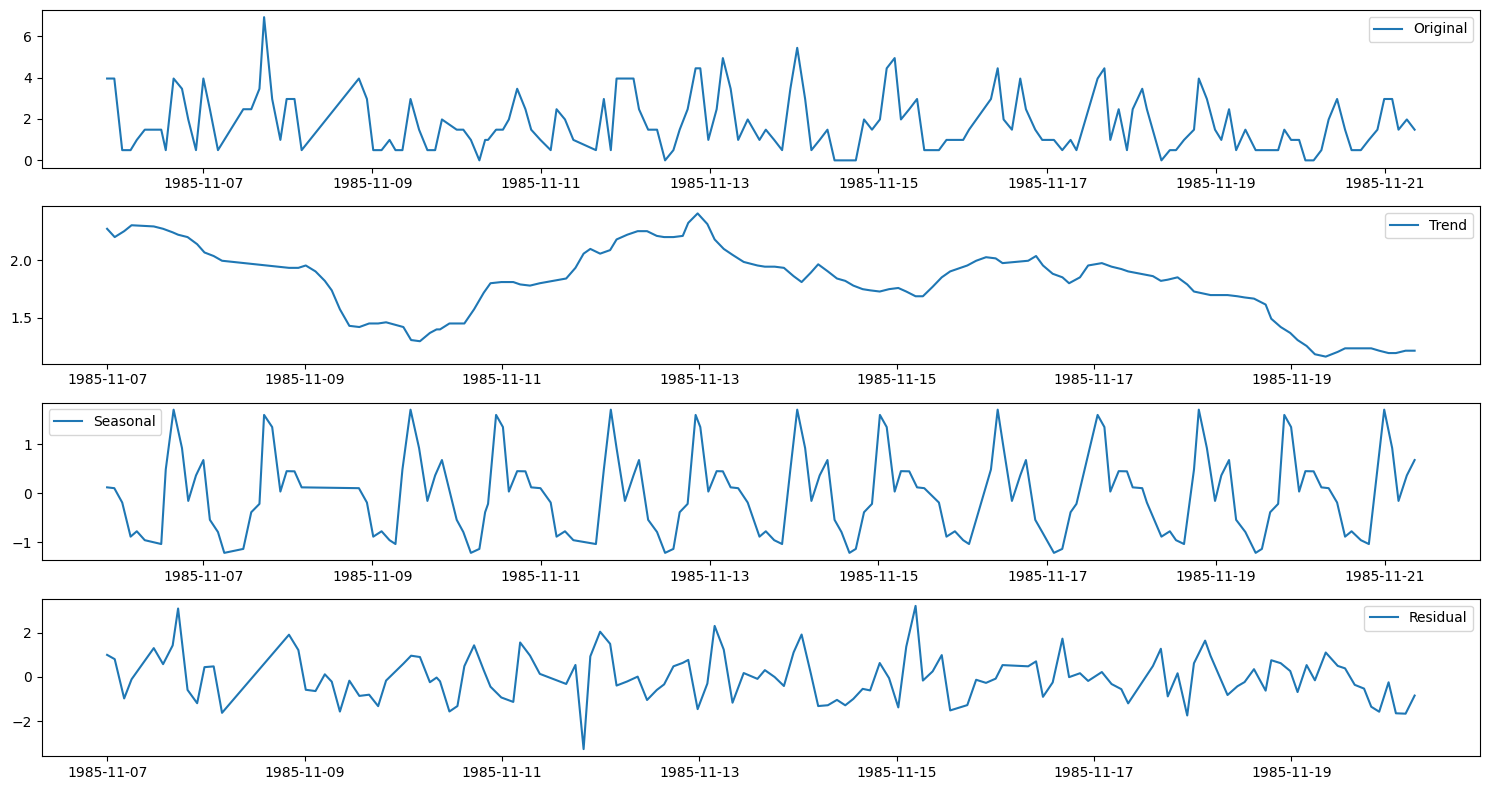


Stationarity Test:
ADF Statistic: -2.533924315630972
p-value: 0.10743681410900624
Critical Values:
	1%: -3.477261624048995
	5%: -2.8821181874544233
	10%: -2.5777431104939494


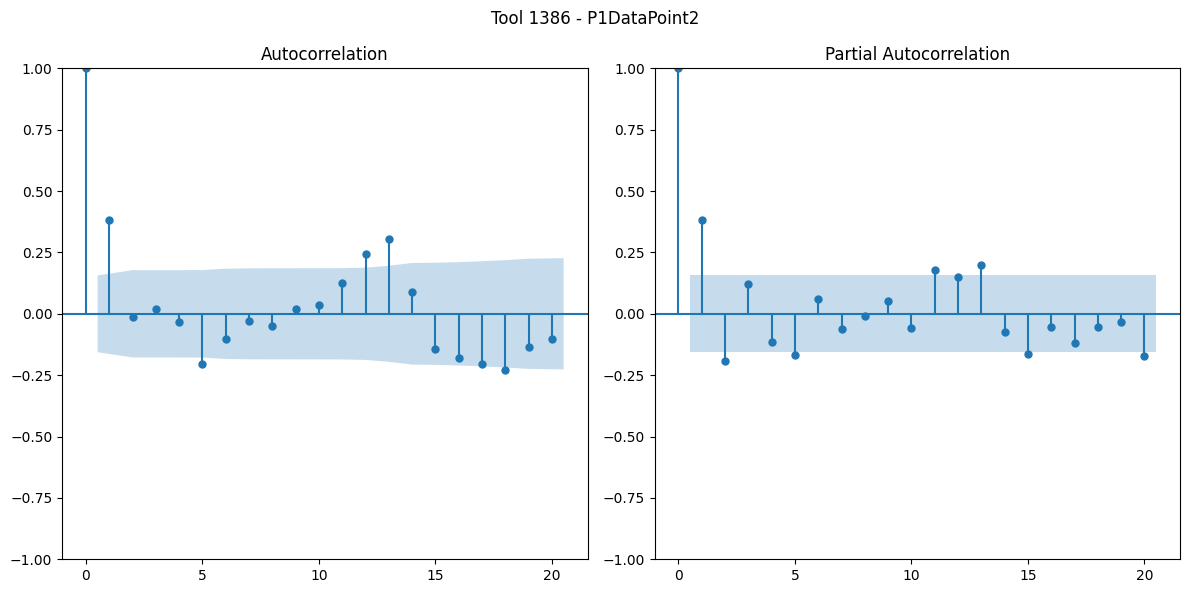

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=446.775, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=432.448, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=425.488, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=573.879, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=424.488, Time=0.03 sec
 ARIMA(0,0,1)(1,0,0)[24] intercept   : AIC=425.203, Time=0.16 sec
 ARIMA(0,0,1)(1,0,1)[24] intercept   : AIC=inf, Time=1.26 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=426.319, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[24] intercept   : AIC=426.278, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=431.920, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[24] intercept   : AIC=423.744, Time=0.32 sec
 ARIMA(1,0,2)(1,0,0)[24] intercept   : AIC=424.445, Time=1.13 sec
 ARIMA(1,0,2)(0,0,1)[24] intercept   : AIC=424.903, Time=1.12 sec
 ARIMA(1,0,2)(1,0,1)[24] intercept   : AI

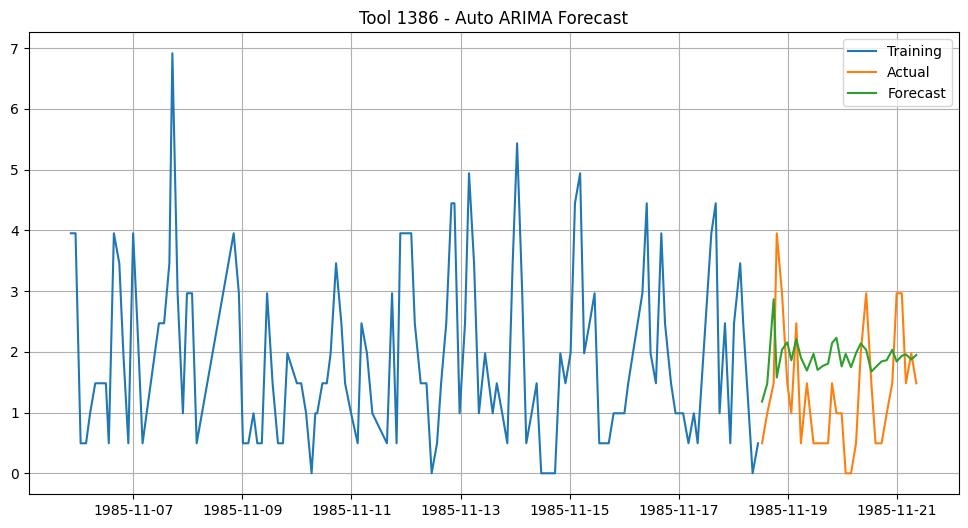

MAE: 0.97
RMSE: 1.11

Analyzing Tool 1836 - P1DataPoint2


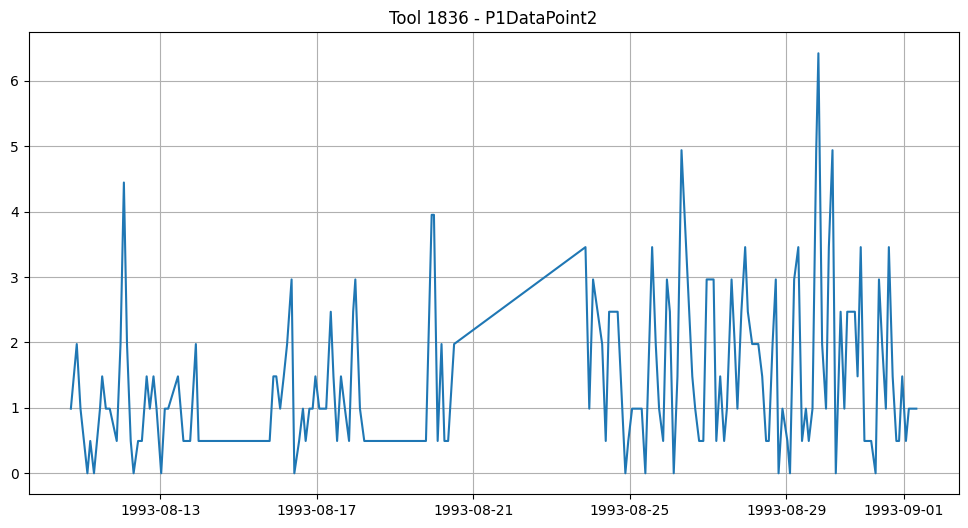

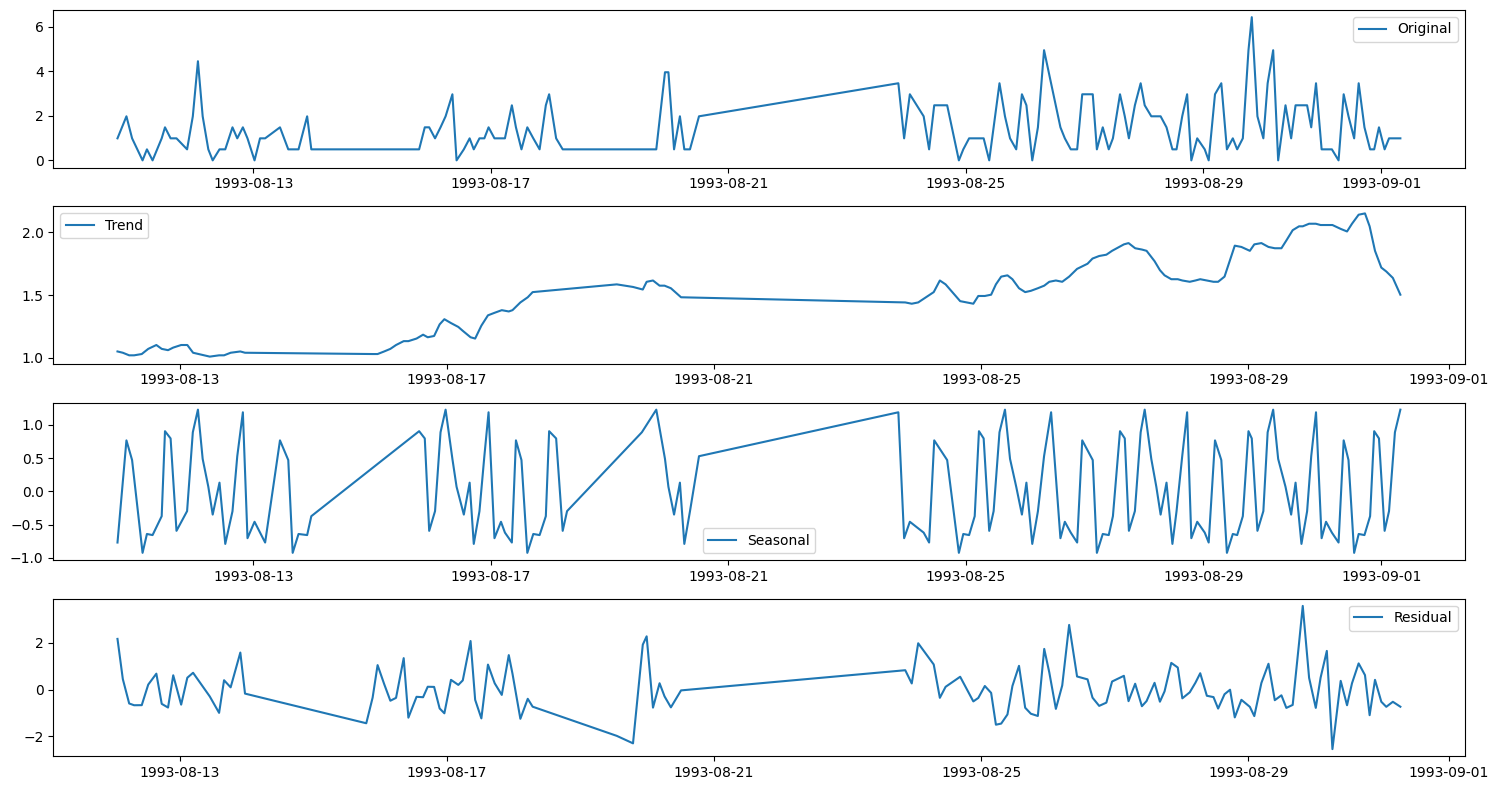


Stationarity Test:
ADF Statistic: -3.8739113414812247
p-value: 0.002235458773391655
Critical Values:
	1%: -3.4744158894942156
	5%: -2.880878382771059
	10%: -2.577081275821236


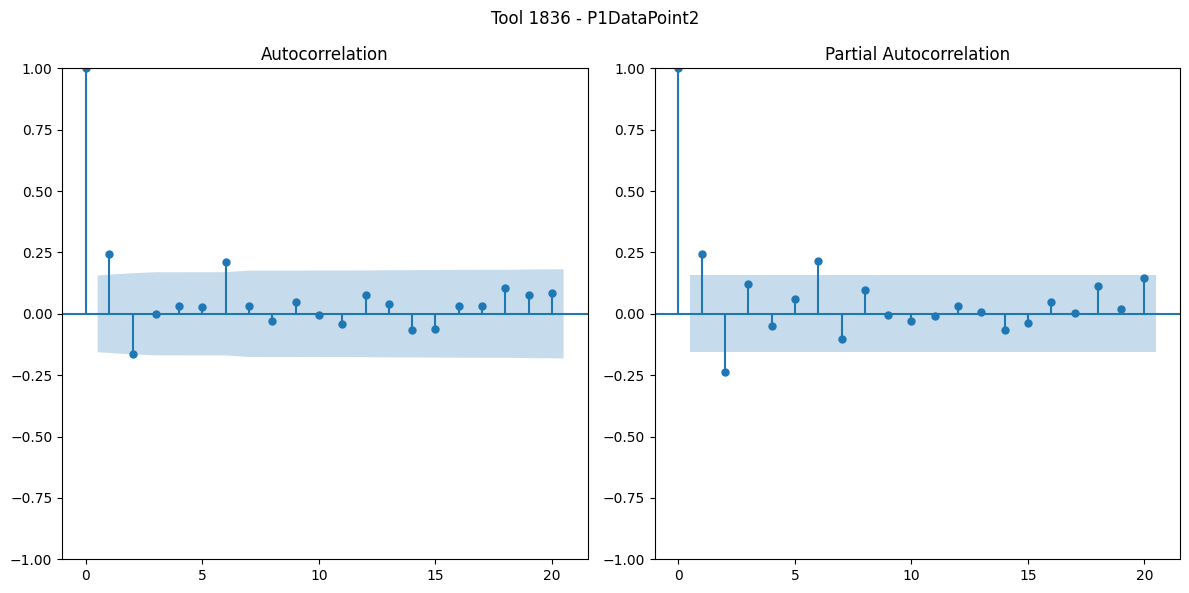

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=352.978, Time=1.19 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=424.560, Time=0.00 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=417.546, Time=0.11 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=422.560, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[24] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(2,1,2)(1,0,0)[24] intercept   : AIC=inf, Time=1.16 sec
 ARIMA(2,1,2)(2,0,1)[24] intercept   : AIC=354.843, Time=4.26 sec
 ARIMA(2,1,2)(1,0,2)[24] intercept   : AIC=inf, Time=4.68 sec
 ARIMA(2,1,2)(0,0,0)[24] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(2,1,2)(0,0,2)[24] intercept   : AIC=inf, Time=3.44 sec
 ARIMA(2,1,2)(2,0,0)[24] intercept   : AIC=353.181, Time=3.97 sec
 ARIMA(2,1,2)(2,0,2)[24] intercept   : AIC=inf, Time=5.29 sec
 ARIMA(1,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(2,1,1)(1,0,1)[24] intercept   : AIC=inf, Time=1.17 sec
 AR

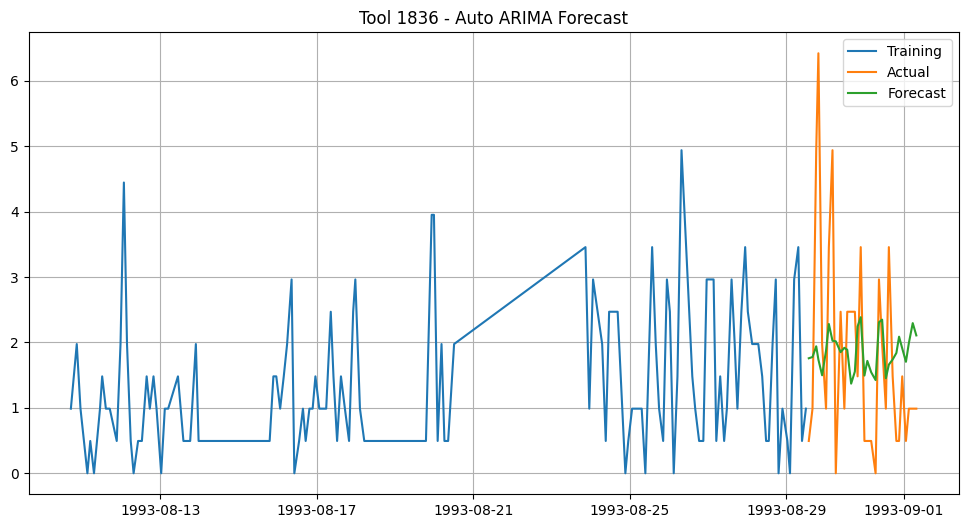

MAE: 1.23
RMSE: 1.51


In [9]:
# Get top 5 tools again to ensure we're using the same list
top_5_tools = df['ToolId'].value_counts().head(5).index.tolist()

# Analyze each of the top 5 tools
for tool_id in top_5_tools:
    analyze_tool(tool_id)